# Imports

In [90]:
import pandas as pd
from json_functions import create_df_big_output, create_example

players_list, df = create_df_big_output('very-big.json', mirror=True)

In [2]:
import numpy as np
import tensorflow as tf
import os

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import tensorflow.keras.backend as K 

In [4]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

     |████████████████████████████████| 1.0MB 9.4MB/s 


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

# Check GPU

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Create dataset from json file

In [7]:
features, outputs = df["rosters vector"], df['rating vector']

features = pd.DataFrame(features.values.tolist(), index= df.index)
outputs = pd.DataFrame(outputs.values.tolist(), index= df.index)

print(np.shape(features))
print(np.shape(outputs))

(17488, 1068)
(17488, 1068)


In [8]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(features, outputs, test_size=0.1, random_state=42)

# I'm just going to use train_test_split again to create a validation dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

validation_ds = (X_val, y_val)

In [9]:
print(len(X_train))
print(len(X))

14165
15739


# Set a global batch size and steps per epoch

I need to set the global batch size for my custom loss function to work.

In [10]:
# I'll use steps per epoch instead of batch size because my custom loss function could be innacurate on a smaller batch at end of training set
GLOBAL_BATCH_SIZE = 329
STEPS_PER_EPOCH = len(X_train)//GLOBAL_BATCH_SIZE

# Create custom loss function

I have extracted my custom loss function to another file. 

It is basically MAE where each result in our output vector is "filtered" by a binary step function, which I made with a sigmoid. 

The sigmoid defined by my_step is very close to a step function, if x = 0, then it will return nearly 0, and if x is a reasonable rating value, even something as low as 0.4, it will return (pretty much) 1. I will plug in y_true to this and then multiply the result by the error so that error on predictions where where y_true = 0 becomes tiny but where y_true is an actual rating stays pretty much the same

In [11]:
from custom_loss import filtered_mae

# Create Compile and fit fucntion

In [12]:
def compile_and_fit(model, 
                    name,
                    max_epochs=1000, 
                    initial_lr=0.001, 
                    es_patience=50,
                    verbose=0):

    # Reduce the learning rate as training goes on
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_lr,
        decay_steps=STEPS_PER_EPOCH*0.1*max_epochs,
        decay_rate=1,
        staircase=False)
    
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=es_patience, 
                                                      verbose=1)

    model.compile(loss=filtered_mae(GLOBAL_BATCH_SIZE),
                  optimizer=tf.keras.optimizers.Adam(lr_schedule))
    
    for output in model.outputs:
        output._uses_learning_phase = True

    model.summary()

    history = model.fit(X_train,
                        y_train, 
                        verbose=verbose, 
                        epochs=max_epochs,
                        # steps_per_epoch=STEPS_PER_EPOCH,
                        batch_size = GLOBAL_BATCH_SIZE,
                        validation_data=validation_ds,
                        validation_batch_size = GLOBAL_BATCH_SIZE,
                        # validation_steps=STEPS_PER_EPOCH//10,
                        callbacks=[early_stopping])
    print("Evaluation on test set:")
    mae = model.evaluate(X_test, y_test,
                         verbose=1,
                         batch_size = GLOBAL_BATCH_SIZE)
    
    return history


# Train a few models with different Architectures

In [13]:
n_inputs, n_outputs = features.shape[1], outputs.shape[1]
n_inputs

1068

In [14]:
linear_perceptron_model = Sequential([
    Dense(n_outputs, input_dim=n_inputs, activation='linear')
])

In [15]:
histories = {}
histories['linear'] =  compile_and_fit(model=linear_perceptron_model,
                                       name='linear',
                                       initial_lr=0.005,
                                       verbose=1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1068)              1141692   
Total params: 1,141,692
Trainable params: 1,141,692
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
44/44 [==============================] - 4s 27ms/step - loss: 0.7251 - val_loss: 0.2603
Epoch 2/1000
44/44 [==============================] - 0s 6ms/step - loss: 0.2507 - val_loss: 0.2496
Epoch 3/1000
44/44 [==============================] - 0s 6ms/step - loss: 0.2203 - val_loss: 0.2524
Epoch 4/1000
44/44 [==============================] - 0s 6ms/step - loss: 0.2132 - val_loss: 0.2550
Epoch 5/1000
44/44 [==============================] - 0s 6ms/step - loss: 0.2094 - val_loss: 0.2577
Epoch 6/1000
44/44 [==============================] - 0s 6ms/step - loss: 0.2057 - val_loss: 0.2579
Epoch 7/1000
44/44 [===================

In [38]:
tanh_perceptron_model = Sequential([
    Dense(n_outputs, input_dim=n_inputs, activation='tanh')
])

In [39]:
histories['tanh_peceptron'] = compile_and_fit(model=tanh_perceptron_model,
                                              name='tanh_peceptron',
                                              initial_lr=0.005)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 1068)              1141692   
Total params: 1,141,692
Trainable params: 1,141,692
Non-trainable params: 0
_________________________________________________________________
Epoch 00062: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss: 0.2522


In [40]:
medium_model = Sequential([
    Dense(1068, input_dim=n_inputs, activation='relu'),
    Dense(2136, activation='relu'),
    Dense(n_outputs)
])
histories['medium_model'] = compile_and_fit(model=medium_model,
                                            name='medium_model',
                                            initial_lr=0.001)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dense_47 (Dense)             (None, 2136)              2283384   
_________________________________________________________________
dense_48 (Dense)             (None, 1068)              2282316   
Total params: 5,707,392
Trainable params: 5,707,392
Non-trainable params: 0
_________________________________________________________________
Epoch 00053: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 5ms/step - loss: 0.2623


In [42]:
medium_model_regularized = Sequential([
    Dense(1068, 
          input_dim=n_inputs,
          kernel_regularizer=regularizers.l2(0.001),
          activation='relu'),
    Dense(2136, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dense(n_outputs)
])
histories['medium_model_reg'] = compile_and_fit(model=medium_model_regularized,
                                                name='medium_model_reg', 
                                                max_epochs=1000, 
                                                initial_lr=0.001)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dense_53 (Dense)             (None, 2136)              2283384   
_________________________________________________________________
dense_54 (Dense)             (None, 1068)              2282316   
Total params: 5,707,392
Trainable params: 5,707,392
Non-trainable params: 0
_________________________________________________________________
Epoch 00113: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss: 0.2331


In [43]:
medium_model_dropout = Sequential([
    Dense(1068, input_dim=n_inputs, activation='relu'),
    Dropout(0.5),
    Dense(2136, activation='relu'),
    Dropout(0.5),
    Dense(n_outputs)
])
histories['medium_model_dropout'] = compile_and_fit(model=medium_model_dropout,
                                                    name='medium_model_dropout',
                                                    max_epochs=1000,
                                                    initial_lr=0.001)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1068)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 2136)              2283384   
_________________________________________________________________
dropout_9 (Dropout)          (None, 2136)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 1068)              2282316   
Total params: 5,707,392
Trainable params: 5,707,392
Non-trainable params: 0
_________________________________________________________________
Epoch 00052: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss

In [44]:
medium_model_dropout_regularized = Sequential([
    Dense(1068,
          input_dim=n_inputs,
          kernel_regularizer=regularizers.l2(0.001),
          activation='relu'),
    Dropout(0.5),
    Dense(2136, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(n_outputs)
])
histories['medium_dropout_regularized'] = compile_and_fit(model=medium_model_dropout_regularized, 
                                                          name='medium_dropout_regularized',
                                                          max_epochs=1000, 
                                                          initial_lr=0.001)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1068)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 2136)              2283384   
_________________________________________________________________
dropout_11 (Dropout)         (None, 2136)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 1068)              2282316   
Total params: 5,707,392
Trainable params: 5,707,392
Non-trainable params: 0
_________________________________________________________________
Epoch 00301: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss

In [45]:
histories

{'huge_regularized_dropout': <tensorflow.python.keras.callbacks.History at 0x7f55c252dfd0>,
 'large_reg': <tensorflow.python.keras.callbacks.History at 0x7f55c267c710>,
 'large_reg_dropout': <tensorflow.python.keras.callbacks.History at 0x7f55de32acd0>,
 'linear': <tensorflow.python.keras.callbacks.History at 0x7f55f023d890>,
 'medium_dropout_regularized': <tensorflow.python.keras.callbacks.History at 0x7f55a459c1d0>,
 'medium_model': <tensorflow.python.keras.callbacks.History at 0x7f55b824a090>,
 'medium_model_dropout': <tensorflow.python.keras.callbacks.History at 0x7f55a44d19d0>,
 'medium_model_reg': <tensorflow.python.keras.callbacks.History at 0x7f55a46f7ad0>,
 'small_reg': <tensorflow.python.keras.callbacks.History at 0x7f55de155450>,
 'small_reg_2': <tensorflow.python.keras.callbacks.History at 0x7f55da4cd850>,
 'tanh_peceptron': <tensorflow.python.keras.callbacks.History at 0x7f55b83b0b50>}

In [21]:
small_regularized_model = Sequential([
    Dense(1068, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dense(n_outputs)
])
histories['small_reg'] = compile_and_fit(model=small_regularized_model, 
                                                        name='small_regularized',
                                                        max_epochs=1000, 
                                                        initial_lr=0.001,
                                                        verbose=0)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1068)              1141692   
_________________________________________________________________
dense_8 (Dense)              (None, 1068)              1141692   
Total params: 2,283,384
Trainable params: 2,283,384
Non-trainable params: 0
_________________________________________________________________
Epoch 00070: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss: 0.2521


In [25]:
small_regularized_model_2 = Sequential([
    Dense(1068, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.05), activation='relu'),
    Dense(n_outputs)
])
histories['small_reg_2'] = compile_and_fit(model=small_regularized_model, 
                                                        name='small_regularized_2',
                                                        max_epochs=1000, 
                                                        initial_lr=0.001,
                                                        verbose=0)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1068)              1141692   
_________________________________________________________________
dense_8 (Dense)              (None, 1068)              1141692   
Total params: 2,283,384
Trainable params: 2,283,384
Non-trainable params: 0
_________________________________________________________________
Epoch 00115: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss: 0.2615


Text(0.5, 0, 'Epochs [Log Scale]')

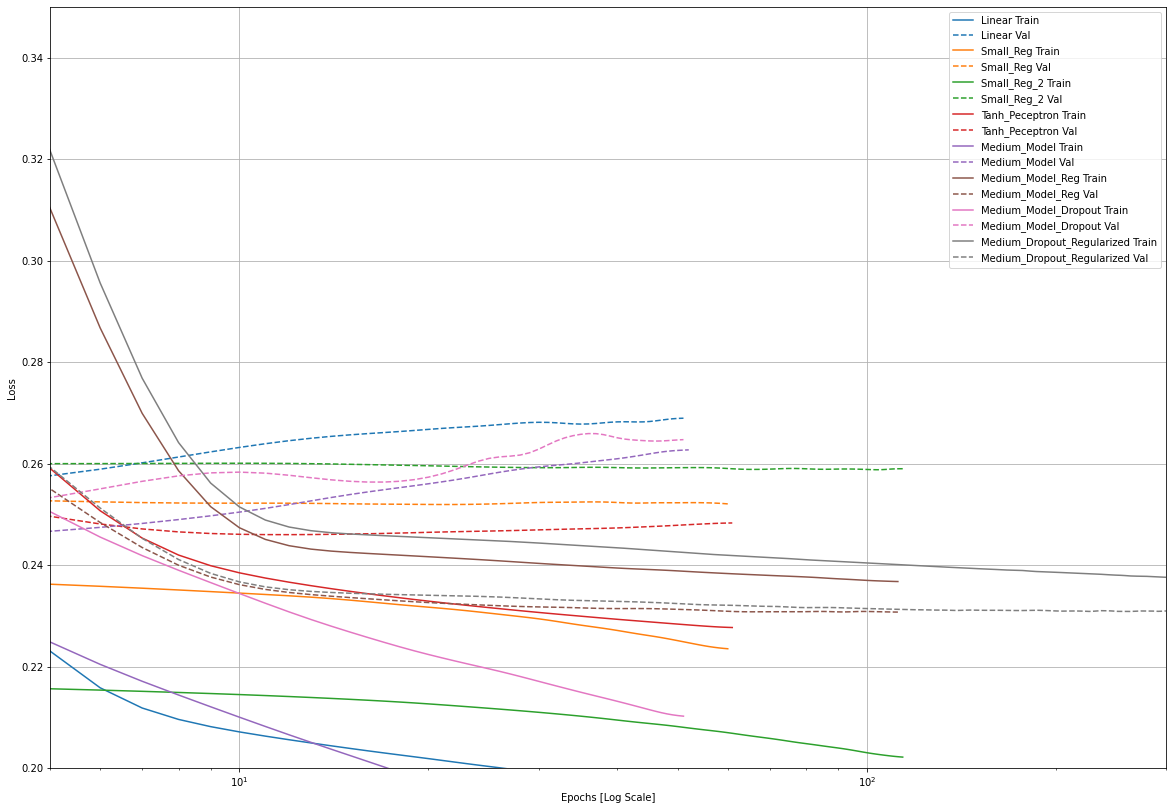

In [46]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)

plt.figure(figsize = (20,14))

plotter.plot(histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.2, 0.35])
plt.xlabel("Epochs [Log Scale]")

The medium model with dropout and regularization performed the best so far

## Bigger Models

In [48]:
histories_big = {}

In [49]:
large_regularized_model = Sequential([
    Dense(1068, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dense(2136, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dense(1068, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dense(n_outputs)
])
histories_big['large_reg'] = compile_and_fit(model=large_regularized_model, 
                                                        name='large_reg',
                                                        max_epochs=1000, 
                                                        initial_lr=0.001,
                                                        verbose=0)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dense_62 (Dense)             (None, 2136)              2283384   
_________________________________________________________________
dense_63 (Dense)             (None, 1068)              2282316   
_________________________________________________________________
dense_64 (Dense)             (None, 1068)              1141692   
Total params: 6,849,084
Trainable params: 6,849,084
Non-trainable params: 0
_________________________________________________________________
Epoch 00211: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss: 0.2334


In [50]:
large_regularized_drop_model = Sequential([
    Dense(1068, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dense(2136, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(1068, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(n_outputs)
])
histories_big['large_reg_dropout'] = compile_and_fit(model=large_regularized_drop_model, 
                                                        name='large_reg_dropout',
                                                        max_epochs=1000, 
                                                        initial_lr=0.001,
                                                        verbose=0)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dense_66 (Dense)             (None, 2136)              2283384   
_________________________________________________________________
dropout_12 (Dropout)         (None, 2136)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 1068)              2282316   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1068)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 1068)              1141692   
Total params: 6,849,084
Trainable params: 6,849,084
Non-trainable params: 0
___________________________________________

In [51]:
huge_regularize_dropout_model = Sequential([
    Dense(2000, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dense(4000, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(8000, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(4000, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(2000, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(1068, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dense(n_outputs)
])
histories_big['huge_regularized_dropout'] = compile_and_fit(model=huge_regularize_dropout_model, 
                                                        name='huge_regularized_dropout',
                                                        max_epochs=1000, 
                                                        initial_lr=0.001,
                                                        verbose=2)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 2000)              2138000   
_________________________________________________________________
dense_70 (Dense)             (None, 4000)              8004000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 4000)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 8000)              32008000  
_________________________________________________________________
dropout_15 (Dropout)         (None, 8000)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 4000)              32004000  
_________________________________________________________________
dropout_16 (Dropout)         (None, 4000)            

In [56]:
histories

{'linear': <tensorflow.python.keras.callbacks.History at 0x7f55f023d890>,
 'medium_dropout_regularized': <tensorflow.python.keras.callbacks.History at 0x7f55a459c1d0>,
 'medium_model': <tensorflow.python.keras.callbacks.History at 0x7f55b824a090>,
 'medium_model_dropout': <tensorflow.python.keras.callbacks.History at 0x7f55a44d19d0>,
 'medium_model_reg': <tensorflow.python.keras.callbacks.History at 0x7f55a46f7ad0>,
 'small_reg': <tensorflow.python.keras.callbacks.History at 0x7f55de155450>,
 'small_reg_2': <tensorflow.python.keras.callbacks.History at 0x7f55da4cd850>,
 'tanh_peceptron': <tensorflow.python.keras.callbacks.History at 0x7f55b83b0b50>}

In [57]:
histories_big['medium_model_reg'] = histories['medium_model_reg']

Text(0.5, 0, 'Epochs [Log Scale]')

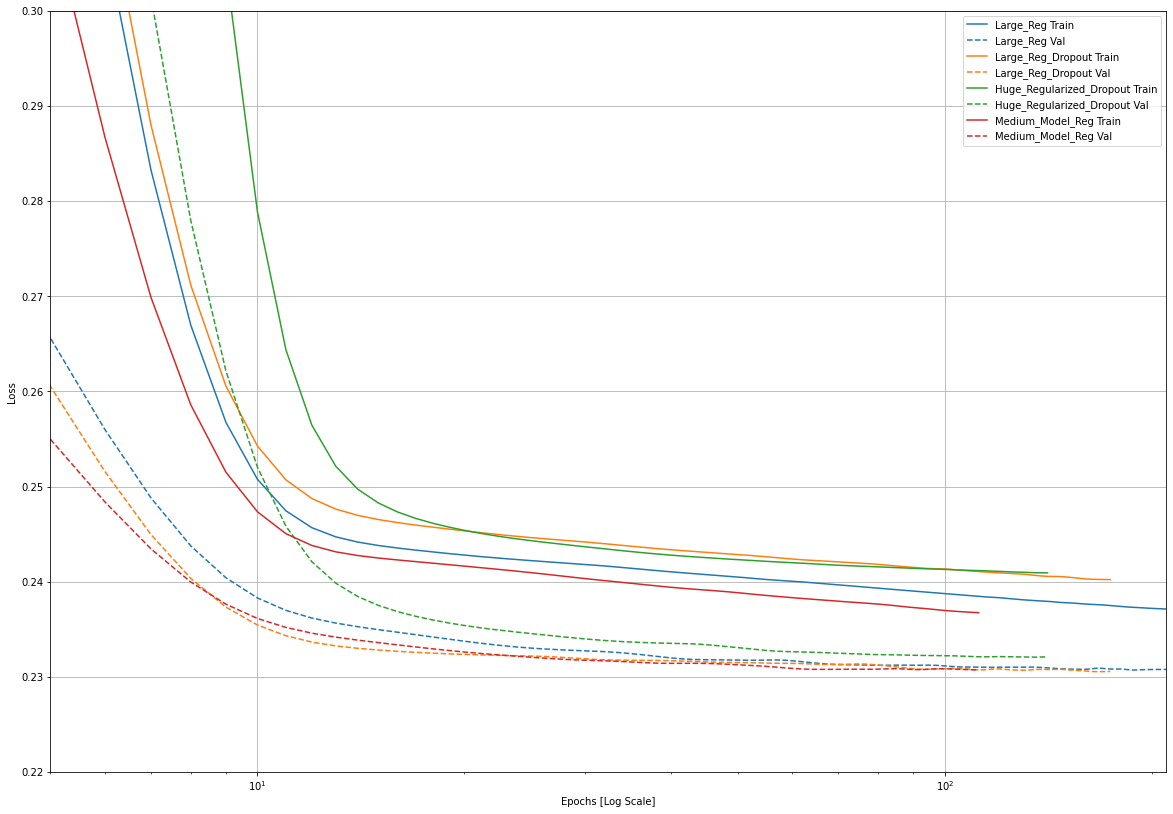

In [58]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)

plt.figure(figsize = (20,14))

plotter.plot(histories_big)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.22, 0.3])
plt.xlabel("Epochs [Log Scale]")

Despite being way bigger than the medium model the huge model perform no better. I think this implies that the problem is only solvable to this degree with the information I'm giving the model.

In [20]:
medium_model_regularized.save('med_l2reg.h5')

# Expirement with our model

In [59]:
model = medium_model_regularized


## Function to print the output of a single prediction

In [60]:
def print_prediction(example, players_list, model):
    player_indices = [i for i, x in enumerate(example) if x == 1]
    example_formatted = np.asarray([example])
    pred = model.predict(example_formatted)

    relevent_preds = np.zeros(10)

    print("Team 1:")
    for i, player  in enumerate(player_indices):
        if player >= len(players_list): player =player - len(players_list)
        print(f'{players_list[player]:10} {round(pred[0][player], 2):.2f}')
        relevent_preds[i] = round(pred[0][player], 2) 
        if i == 4:
            print("Agregate Rating:", round(np.sum(relevent_preds[0:5]), 2))
            print("Team 2:")
        if i == 9:
            print("Agregate Rating:", round(np.sum(relevent_preds[5:10]), 2))


## Predict on some games

In [61]:
hypothetical = create_example(['EliGE', 'Stewie2K', 'Grim', 'FalleN', 'NAF'], ['device', 'Xyp9x', 'Magisk', 'dupreeh', 'gla1ve'], players_list)


In [62]:
print_prediction(hypothetical, players_list, model)

Team 1:
EliGE      1.03
NAF        1.03
Stewie2K   0.87
FalleN     0.89
Grim       0.93
Agregate Rating: 4.75
Team 2:
device     1.21
dupreeh    1.14
Xyp9x      1.08
gla1ve     1.04
Magisk     1.13
Agregate Rating: 5.6


Let's compare these results to a real game played between these two teams that happened after I collected the training data (the model hasn't seen this game):

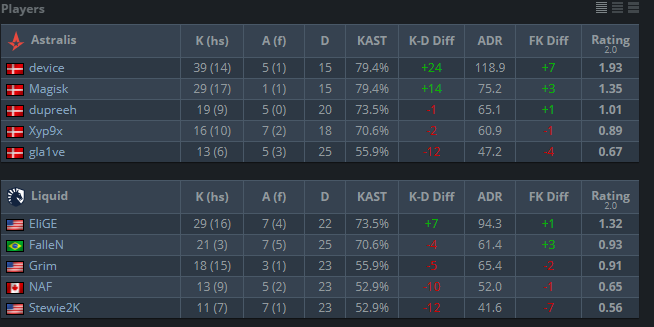
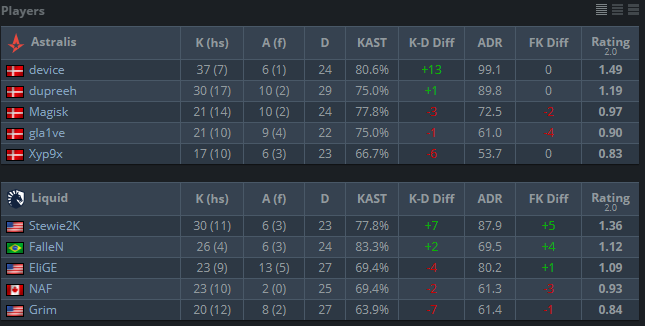

Well, it didn't do a fantastic job at predicting individual ratings here. But at least it knew device would do the best on Astralis. I guess its not surprising that the model doesn't predict super well on individual games since performance can vary so extremely from game to game (as exemplified by Stewie2K here)

One thing it does get right is the winner of the game, if we assume that whoever has the higher agregate rating would win (It would be virtually impossible to win a CSGO game with a team that has a lower agregate rating, so this is a fair assumption)

Lets check that the order of teams doesn't have too much of an effect on the results:

In [63]:
hypothetical = create_example(['device', 'Xyp9x', 'Magisk', 'dupreeh', 'gla1ve'], ['EliGE', 'Stewie2K', 'Grim', 'FalleN', 'NAF'], players_list)
print_prediction(hypothetical, players_list, model)

Team 1:
device     1.21
dupreeh    1.14
Xyp9x      1.10
gla1ve     1.05
Magisk     1.14
Agregate Rating: 5.64
Team 2:
EliGE      1.04
NAF        1.04
Stewie2K   0.88
FalleN     0.90
Grim       0.94
Agregate Rating: 4.8


So the order of the teams doesn't matter. That's good.

## Old Astralis vs New Astralis

Here's a hypothetical game that could never happen: 2016 Astralis vs current Astralis. Current Astralis is the most dominant CSGO roster of all time, so we would expect to see higher ratings accross the board for them, which we do. (They are team 2 here).

In [64]:
hypothetical = create_example(['device', 'Xyp9x', 'Kjaerbye', 'dupreeh', 'karrigan'], ['device', 'Xyp9x', 'Magisk', 'dupreeh', 'gla1ve'], players_list)
print_prediction(hypothetical, players_list, model)

Team 1:
karrigan   0.75
device     1.15
dupreeh    1.09
Xyp9x      1.03
Kjaerbye   0.83
Agregate Rating: 4.85
Team 2:
device     1.15
dupreeh    1.09
Xyp9x      1.03
gla1ve     0.99
Magisk     1.08
Agregate Rating: 5.34


Let's see how the model says each of these Astralis's would do against FaZe

In [65]:
hypothetical = create_example(['device', 'Xyp9x', 'Kjaerbye', 'dupreeh', 'karrigan'], ['flamie', 's1mple', 'electronic', 'Boombl4', 'Perfecto'], players_list)
print_prediction(hypothetical, players_list, model)

Team 1:
karrigan   0.80
device     1.20
dupreeh    1.13
Xyp9x      1.08
Kjaerbye   0.87
Agregate Rating: 5.08
Team 2:
s1mple     1.23
flamie     0.92
electronic 1.12
Boombl4    0.97
Perfecto   0.93
Agregate Rating: 5.17


In [66]:
hypothetical = create_example(['device', 'Xyp9x', 'Magisk', 'dupreeh', 'gla1ve'], ['flamie', 's1mple', 'electronic', 'Boombl4', 'Perfecto'], players_list)
print_prediction(hypothetical, players_list, model)

Team 1:
device     1.14
dupreeh    1.08
Xyp9x      1.02
gla1ve     0.98
Magisk     1.07
Agregate Rating: 5.29
Team 2:
s1mple     1.19
flamie     0.88
electronic 1.08
Boombl4    0.95
Perfecto   0.89
Agregate Rating: 4.99


The model says that Old Astralis loses to NaVi while New Astralis wins, which seems pretty much right to me. The model shows that niether device, dupreeh, or Xyp9x perform as well on new astralis, but the rest of the team performs better which more than makes up for it. 

Intuitively this seems right, as Astralis is known for dominating while no one player carries the game. Every player contributes so no individual needs to "pop off".

In [67]:
#TODO
# choose a player, hold opponents equal, then loop thru all possible teammates
# to find best teammates.
# hold 3 teammates equal to find best teammate


In [69]:
example = create_example(['flamie', 's1mple', 'electronic', 'Boombl4', 'Perfecto'], 
                         ['ZywOo'], players_list)
print_prediction(example, players_list, model)

Team 1:
s1mple     1.33
flamie     1.05
electronic 1.19
Boombl4    0.96
Perfecto   1.03
Agregate Rating: 5.56
Team 2:
ZywOo      1.24


In [70]:
example = create_example([], 
                         ['karrigan'], players_list)
print_prediction(example, players_list, model)

Team 1:
karrigan   1.11


In [71]:
def find_best_teammate(player, player_list, model, min_games_together=10):
  from json_functions import get_teammates
  teammates = get_teammates(player, "very-big.json", min_games_together)
  
  player_index = player_list.index(player)
  from json_functions import create_example
  best_rating = 0
  best_teammate = 'none'

  avg_rating = 0
  
  for teammate in teammates:
    if player != teammate:
      example = create_example([player, teammate], [], player_list)
      pred_rating = model.predict(np.asarray([example]))[0][player_index]
      avg_rating += pred_rating
      if pred_rating > best_rating:
        best_rating = pred_rating
        best_teammate = teammate
  avg_rating = avg_rating/len(teammates)
  return best_teammate, best_rating, avg_rating

In [72]:
example = create_example(['karrigan'], 
                         [], players_list)
print_prediction(example, players_list, model)

Team 1:
karrigan   1.11


In [73]:
find_best_teammate("karrigan",
                   players_list, 
                   model)

('NaToSaphiX', 1.1173428, 1.0887110373553108)

In [74]:
find_best_teammate("Stewie2K",
                   players_list, 
                   model)

('autimatic', 1.2383341, 1.2183052367634244)

In [75]:
def make_player_list_min_games(file_to_use, min_games=10):
  import json
  with open(file_to_use, encoding="utf-8") as json_file:
    data = json.load(json_file) 

    players_list = {}
    filtered_players_list = []

    for cs_map in data:
      for player in cs_map['team1']:
        if player['name'] not in players_list:
          players_list[player['name']] = 0
        else:
          players_list[player['name']] = players_list[player['name']] + 1
      for player in cs_map['team2']:
        if player['name'] not in players_list:
          players_list[player['name']] = 0
        else:
          players_list[player['name']] = players_list[player['name']] + 1
    
    for player in players_list:
      if players_list[player] >= min_games:
        filtered_players_list.append(player)

    return  filtered_players_list

In [76]:
# for player in make_player_list_min_games("very-big.json"):

players_list_min_games = make_player_list_min_games("very-big.json", 300)

In [77]:
len(players_list_min_games)

121

In [78]:
best_rating_diff = 0
best_teammates = []
all_pairs = []
for player in players_list_min_games:
  teammate, rating, avg_rating = find_best_teammate(player,
                                                    players_list,
                                                    model,
                                                    min_games_together=150)
  rating_diff = rating - avg_rating
  all_pairs.append([player, teammate, rating_diff])

  if rating_diff > best_rating_diff:
    best_rating_diff = rating_diff
    best_teammates = [player, teammate]
    print(best_teammates, rating_diff)

print(f"{best_teammates[1]} and {best_teammates[0]} have the best chemistry " 
      + f"according to the model. {best_teammates[0]} performs "
      + f"{best_rating_diff:.3f} rating better when he plays with {best_teammates[1]}")


['snatchie', 'Furlan'] 0.004775375127792358
['phr', 'TOAO'] 0.006125843524932839
['XANTARES', 'hardstyle'] 0.013109910488128707
['s1mple', 'Zeus'] 0.014178763736378164
['flamie', 'Zeus'] 0.017315799539739496
['rain', 'YNk'] 0.02177198727925611
['nitr0', 'TACO'] 0.024179172515869096
['tarik', 'crush'] 0.029253678662436444
['device', 'Xyp9x'] 0.033349454402923584
['Kjaerbye', 'MSL'] 0.04054827160305452
MSL and Kjaerbye have the best chemistry according to the model. Kjaerbye performs 0.041 rating better when he plays with MSL


In [79]:
all_pairs = pd.DataFrame(all_pairs, columns =['player', 'helper', 'rating diff'])
all_pairs = all_pairs.sort_values(by=['rating diff'], ascending=False).reset_index(drop=True)
print(all_pairs.head(20))

       player   helper  rating diff
0    Kjaerbye      MSL     0.040548
1      Magisk    Xyp9x     0.037288
2      Snappi   es3tag     0.035732
3      device    Xyp9x     0.033349
4      gla1ve    Xyp9x     0.032495
5       tarik    crush     0.029254
6   EspiranTo    LETN1     0.025240
7       ISSAA    ANGE1     0.025033
8       nitr0     TACO     0.024179
9      chrisJ    Rejin     0.024069
10    dupreeh    Xyp9x     0.023892
11       apEX     NBK-     0.023569
12        mir   magixx     0.023381
13        jks      FNS     0.023189
14   coldzera     swag     0.021775
15       rain      YNk     0.021772
16      STYKO  kRYSTAL     0.021389
17      oskar   chrisJ     0.021247
18        AZR      FNS     0.021168
19   karrigan      ave     0.021089


In [80]:
def roster_to_string(roster):
  str_roster = ""
  for player in roster:
    str_roster = str_roster + player + " "
  return str_roster

def get_lineups(file_to_use, min_games=10):
  import json
  with open(file_to_use, encoding="utf-8") as json_file:
    data = json.load(json_file)
    teams_dict = {}
    teams_list = []
    
    for cs_map in data:
      team1 = roster_to_string(sorted([tm['name'] for tm in cs_map['team1']]))
      team2 = roster_to_string(sorted([tm['name'] for tm in cs_map['team2']]))
      if team1 not in teams_dict:
        teams_dict[team1] = 0
      else:
        teams_dict[team1] = teams_dict[team1] + 1 
      if team2 not in teams_dict:
        teams_dict[team2] = 0
      else:
        teams_dict[team2] = teams_dict[team2] + 1
    

    for team in teams_dict:
      if teams_dict[team] >= min_games:
        team = team.split()
        if len(team) == 5:
          teams_list.append(team)
    return teams_list

In [86]:
lineups = get_lineups("very-big.json", min_games=30)
len(lineups)


156

In [87]:
def find_best_lineups(lineups):
  from json_functions import create_example
  
  lineup_rating = []

  for lineup in lineups:
    example = create_example(lineup, [], players_list)
    player_indices = [i for i, x in enumerate(example) if x == 1]
    if len(player_indices) > 5:
      continue
    pred = model.predict(np.asarray([example]))

    relevent_preds = np.zeros(5)

    for i, player  in enumerate(player_indices):
      relevent_preds[i] = pred[0][player]
    rating = np.sum(relevent_preds)
    
    lineup_rating.append((lineup, rating))
  print(lineup_rating)
  df = pd.DataFrame(lineup_rating, columns =['lineup', 'rating'])
  best_lineups = df.sort_values(by=['rating'], ascending=False).reset_index(drop=True)
  return best_lineups


In [88]:
best_lineups = find_best_lineups(lineups)

[(['Furlan', 'GruBy', 'TOAO', 'phr', 'snatchie'], 5.032610833644867), (['Calyx', 'MAJ3R', 'XANTARES', 'ngiN', 'paz'], 5.502757787704468), (['Edward', 'Zeus', 'electronic', 'flamie', 's1mple'], 5.769599795341492), (['Boombl4', 'Kvik', 'balblna', 'jmqa', 'waterfaLLZ'], 4.427728712558746), (['GuardiaN', 'NiKo', 'karrigan', 'olofmeister', 'rain'], 5.561209976673126), (['STYKO', 'chrisJ', 'oskar', 'ropz', 'suNny'], 5.461091756820679), (['Jame', 'KrizzeN', 'buster', 'dimasick', 'qikert'], 5.477634608745575), (['COLDYY1', 'DavCost', 'Dima', 'S0tF1k', 'sdy'], 5.122834920883179), (['SHiPZ', 'SPELLAN', 'bubble', 'pNshr', 'v1c7oR'], 5.200208604335785), (['RUSH', 'Skadoodle', 'Stewie2K', 'autimatic', 'tarik'], 5.5858957171440125), (['NBK-', 'apEX', 'bodyy', 'kennyS', 'shox'], 5.5118690729141235), (['Golden', 'JW', 'KRIMZ', 'Lekr0', 'flusha'], 5.313262403011322), (['FalleN', 'TACO', 'coldzera', 'felps', 'fer'], 5.382760047912598), (['Brehze', 'CeRq', 'Ethan', 'FugLy', 'daps'], 5.496957063674927), (

In [89]:
best_lineups.head(30)

,lineup,rating
0,"[Magisk, Xyp9x, device, dupreeh, gla1ve]",6.023768
1,"[Magisk, device, dupreeh, es3tag, gla1ve]",5.847981
2,"[Edward, Zeus, electronic, flamie, s1mple]",5.769600
3,"[EliGE, NAF, Twistzz, nitr0, steel]",5.762817
4,"[Brehze, CeRq, Ethan, stanislaw, tarik]",5.712353
5,"[EliGE, Grim, NAF, Stewie2K, Twistzz]",5.712160
6,"[AmaNEk, NiKo, huNter-, kennyS, nexa]",5.710596
7,"[Ax1Le, interz, nafany, sh1ro, supra]",5.705678
8,"[Boombl4, GuardiaN, electronic, flamie, s1mple]",5.696336
9,"[EliGE, NAF, Stewie2K, Twistzz, nitr0]",5.689481


In [211]:
def find_best_roster_for(player):
  for i in range(len(best_lineups)):
    if player in best_lineups.loc[i, 'lineup']:
      return best_lineups.loc[i, 'lineup']
  return "player not found"

In [212]:
find_best_roster_for("NiKo")

['AmaNEk', 'NiKo', 'huNter-', 'kennyS', 'nexa']

In [213]:
find_best_roster_for("karrigan")

['chrisJ', 'frozen', 'karrigan', 'ropz', 'woxic']

In [214]:
find_best_roster_for("coldzera")

['Bymas', 'NiKo', 'broky', 'coldzera', 'rain']

In [217]:
find_best_roster_for("chrisJ")

['chrisJ', 'frozen', 'karrigan', 'ropz', 'woxic']